In [1]:
import pandas as pd
from kan.custom_processing import (plot_data_per_interval,
                                   plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np

plt.rcParams['figure.figsize'] = (15, 8)
# plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_01")
os.makedirs(save_dir, exist_ok=True)

f_param = "P3HT_20251118_1534"
save_heading = os.path.join(save_dir, f_param + "_analysis")
d_opt = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_param + ".xlsx"), sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

# time_stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')
# save_heading = os.path.join(save_dir, "P3HT_" + time_stamp)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch

filepath = os.path.join(root_dir, "data", "P3HT.csv")
filedata = pd.read_csv(filepath)
name_X = filedata.columns[:-1].tolist()
name_y = filedata.columns[-1]
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out, rr=20)

removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

TARGET: Conductivity (measured) (S/cm)
# of data after removing outliers: 232 개 (1 개 제거됨)
Train set: 148 (63.8%)
Validation set: 37 (15.9%)
Test set: 47 (20.3%)


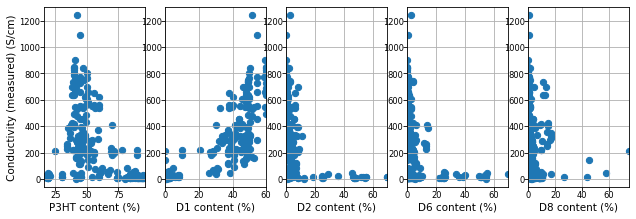

In [3]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:, i], y)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 1.19e-01 | test_loss: 2.04e-01 | reg: 2.75e+00 | : 100%|█| 50/50 [00:06<00:00,  8.24it
| train_loss: 1.19e-01 | test_loss: 2.04e-01 | reg: 2.73e+00 | : 100%|█| 50/50 [00:05<00:00,  9.25it
| train_loss: 1.22e-01 | test_loss: 2.04e-01 | reg: 2.59e+00 | : 100%|█| 50/50 [00:04<00:00, 11.71it
| train_loss: 8.94e-02 | test_loss: 2.21e-01 | reg: 2.53e+00 | : 100%|█| 50/50 [00:04<00:00, 11.17it


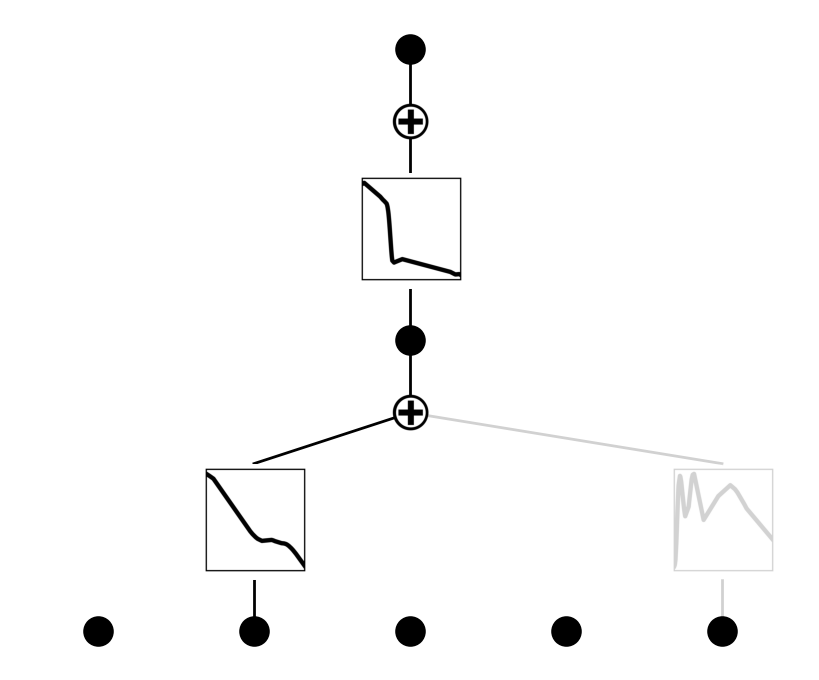

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with 0
r2 is 0.9912847876548767
fixing (0,1,0) with x^3, r2=0.99, c=3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,0) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,0) with 0
Best value at boundary.
r2 is 0.607839047908783
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,4,0) with 1/x^2, r2=0.61, c=2
Best value at boundary.
r2 is 0.8603008985519409
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (1,0,0) with cos, r2=0.86, c=2


| train_loss: 1.36e-01 | test_loss: 2.31e-01 | reg: 9.05e-03 | : 100%|█| 50/50 [00:03<00:00, 12.92it


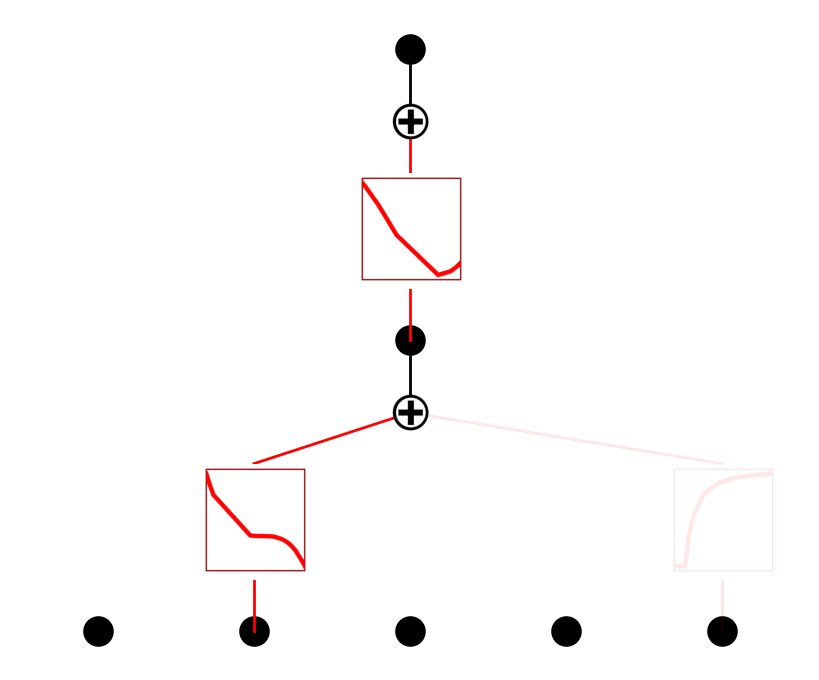

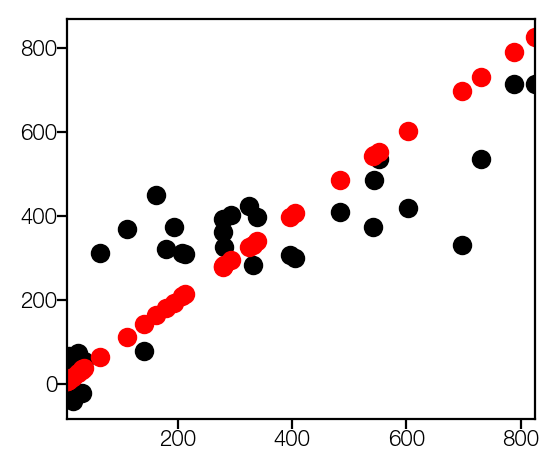

TrialResult(params={'grid': 10, 'k': 3, 'lamb': 0.01, 'lamb_coef': 1, 'lamb_entropy': 0.1, 'lr': 0.1, 'mult_arity': 0, 'opt': 'LBFGS', 'prune': True, 'pruning_edge_th': 0.03, 'pruning_node_th': 0.01, 'steps': 50, 'sym_weight_simple': 0, 'symbolic': True, 'update_grid': True, 'width': [[5, 0], [5, 0], [1, 0]]}, val_loss=101.36271667480469, train_loss=99.63818359375, test_loss=149.17544555664062, r2_train=0.709866643913788, r2_val=0.7154209120929249, r2_test=0.4897627606811251, seed=0, device='cpu', spline_train_loss=0.11751601845026016, spline_test_loss=0.2162468284368515)


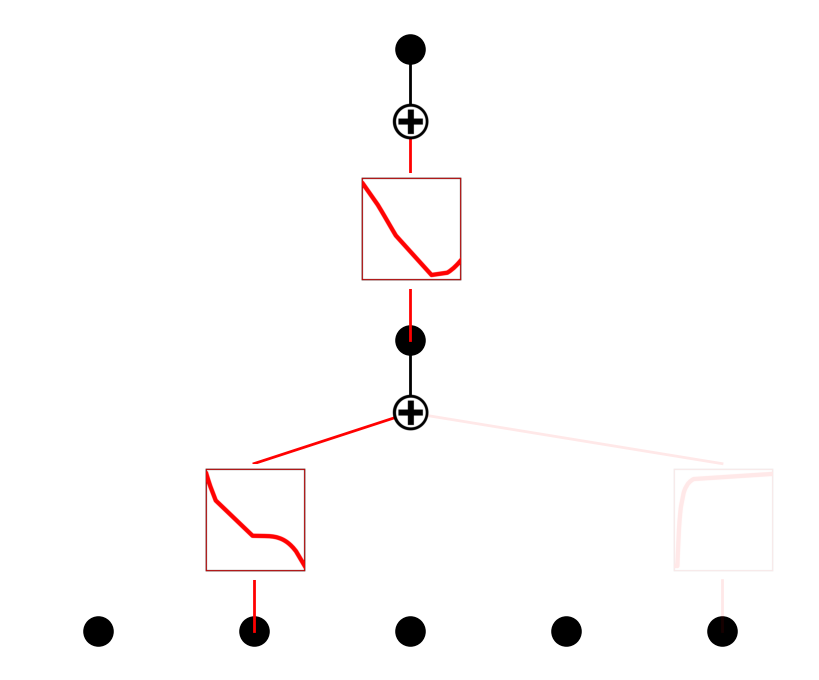

In [4]:
from kan.experiments.multkan_hparam_sweep import evaluate_params

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

{'train': 0.7098666614908494, 'test': 0.4897628097619522}


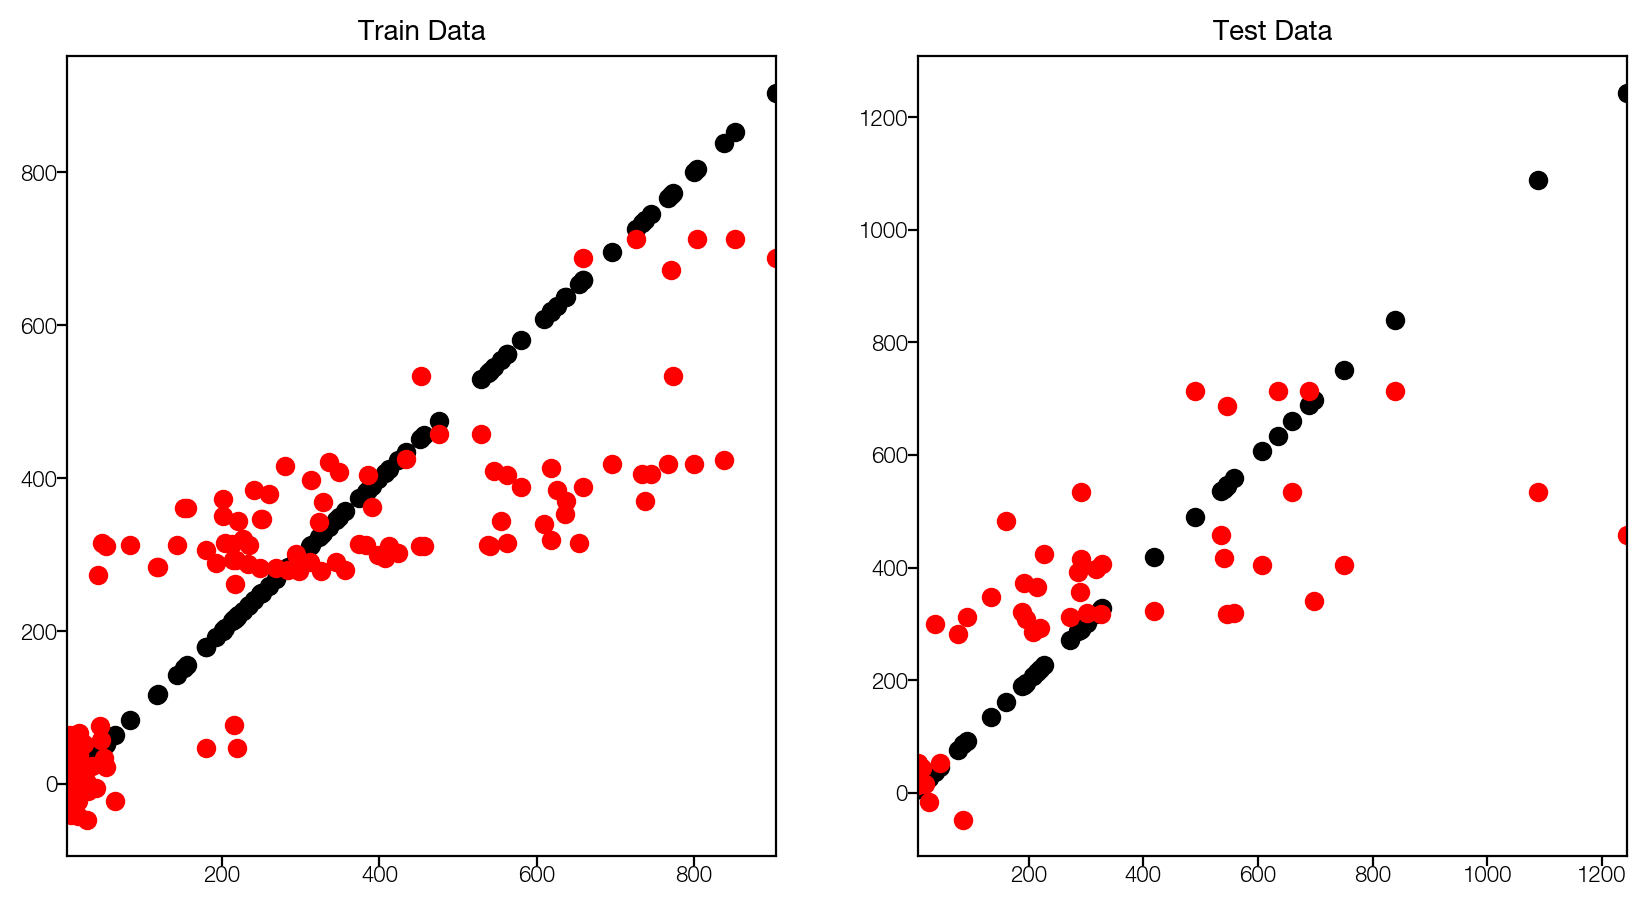

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.show()
plt.show()